In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from pymc import do, observe
import pymc.sampling_jax
import scipy.stats as stats
import seaborn as sns
import arviz as az
import networkx as nx
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- X
    beta_y0 = pm.Normal("beta_y0")
    beta_xy = pm.Normal("beta_xy")
    
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    
    # core node and causal relationship
    x = pm.Normal("x", mu=0, sigma=1, dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_xy * x), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

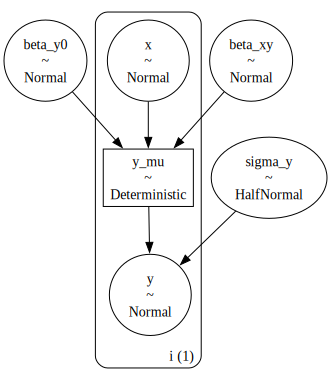

In [4]:
pm.model_to_graphviz(model_generative)

In [5]:
true_values = {
    "beta_y0": 0.25,
    "beta_xy": 1.0,
    "sigma_y": 0.75
}

model_simulate = do(model_generative, true_values)

In [6]:
N = 100 

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=rng)

Sampling: [x, y]


In [7]:
observed = {
    "y": simulate.prior["y"].values.flatten(),
    "x": simulate.prior["x"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("x", ascending=False)
df.shape

(100, 2)

In [8]:
df.head()

,y,x
30,2.522725,2.414043
92,2.783802,1.791996
87,1.013874,1.746753
91,1.397997,1.571990
61,1.050603,1.317880


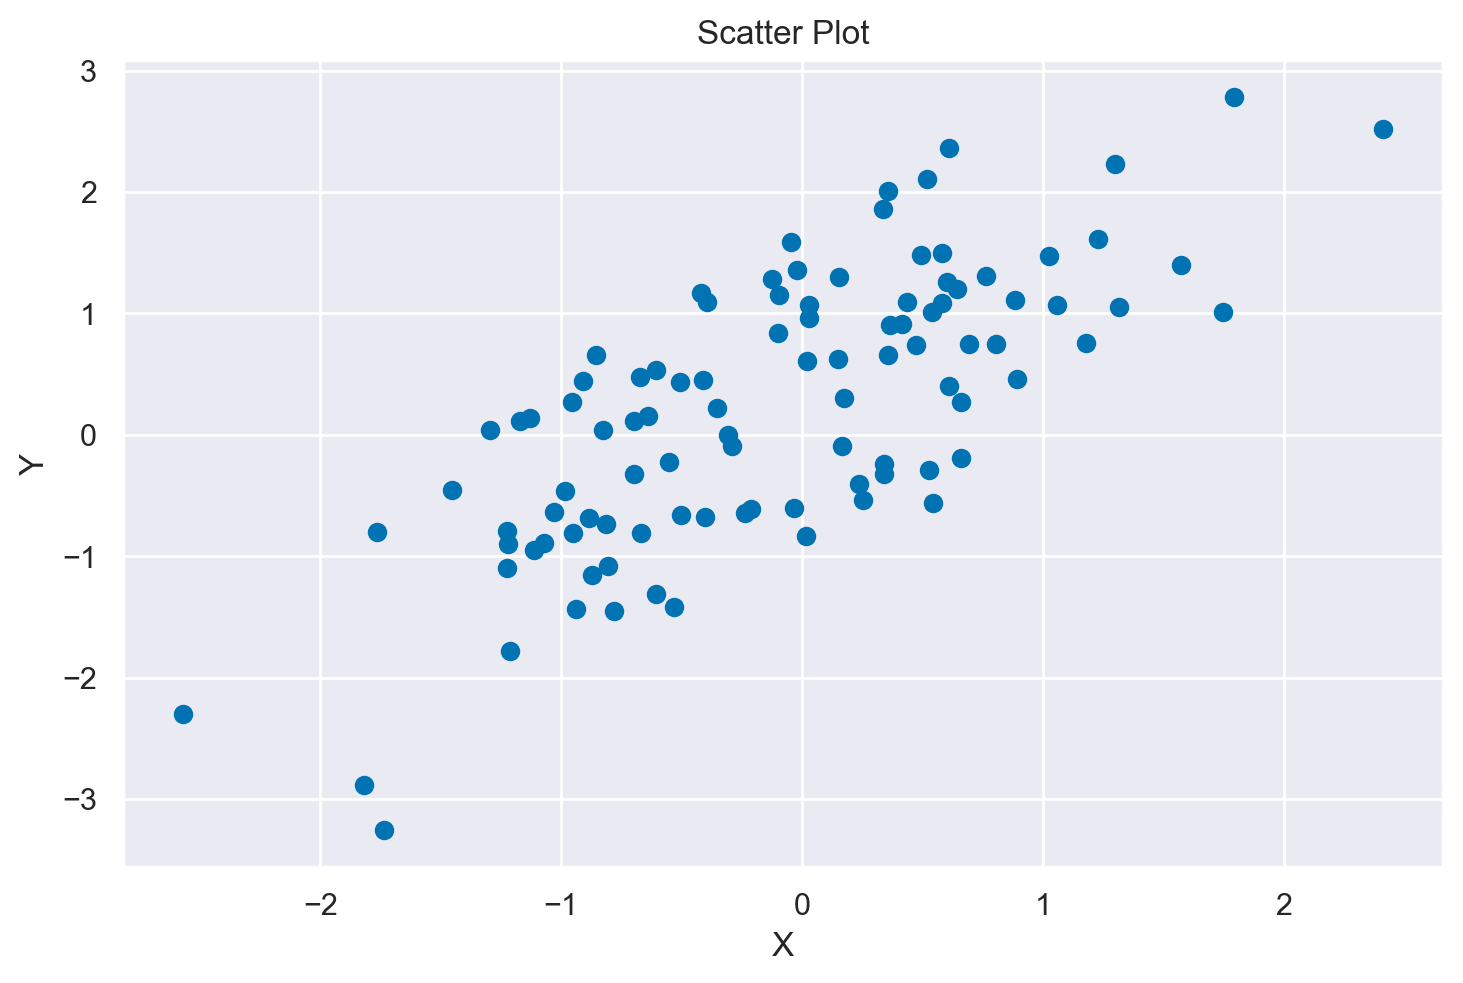

In [9]:
plt.scatter(df["x"], df["y"])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot")
plt.show()

In [10]:
# Numero di osservazioni nei dati
N = len(df)

# Valori osservati
obs_x = df["x"].values
obs_y = df["y"].values

with pm.Model(coords={"i": np.arange(N)}) as model_inference:
    # Priori debolmente informativi su Y <- X
    beta_y0 = pm.Normal("beta_y0", mu=0, sigma=1)
    beta_xy = pm.Normal("beta_xy", mu=0, sigma=1)

    # Rumore delle osservazioni Y
    sigma_y = pm.HalfNormal("sigma_y", sigma=1)

    # Nodo principale e relazione causale (qui usiamo i dati osservati)
    x = pm.Data("x", obs_x, dims="i")

    # Nodo deterministico per la media di Y
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_xy * x), dims="i")

    # Verosimiglianza di Y (qui usiamo i dati osservati)
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, observed=obs_y, dims="i")

In [11]:
with model_inference:
    idata1 = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:00.705924


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1556.30it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1557.77it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1559.97it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1561.67it/s]


Sampling time = 0:00:01.490538


Transforming variables...


Transformation time = 0:00:00.093446


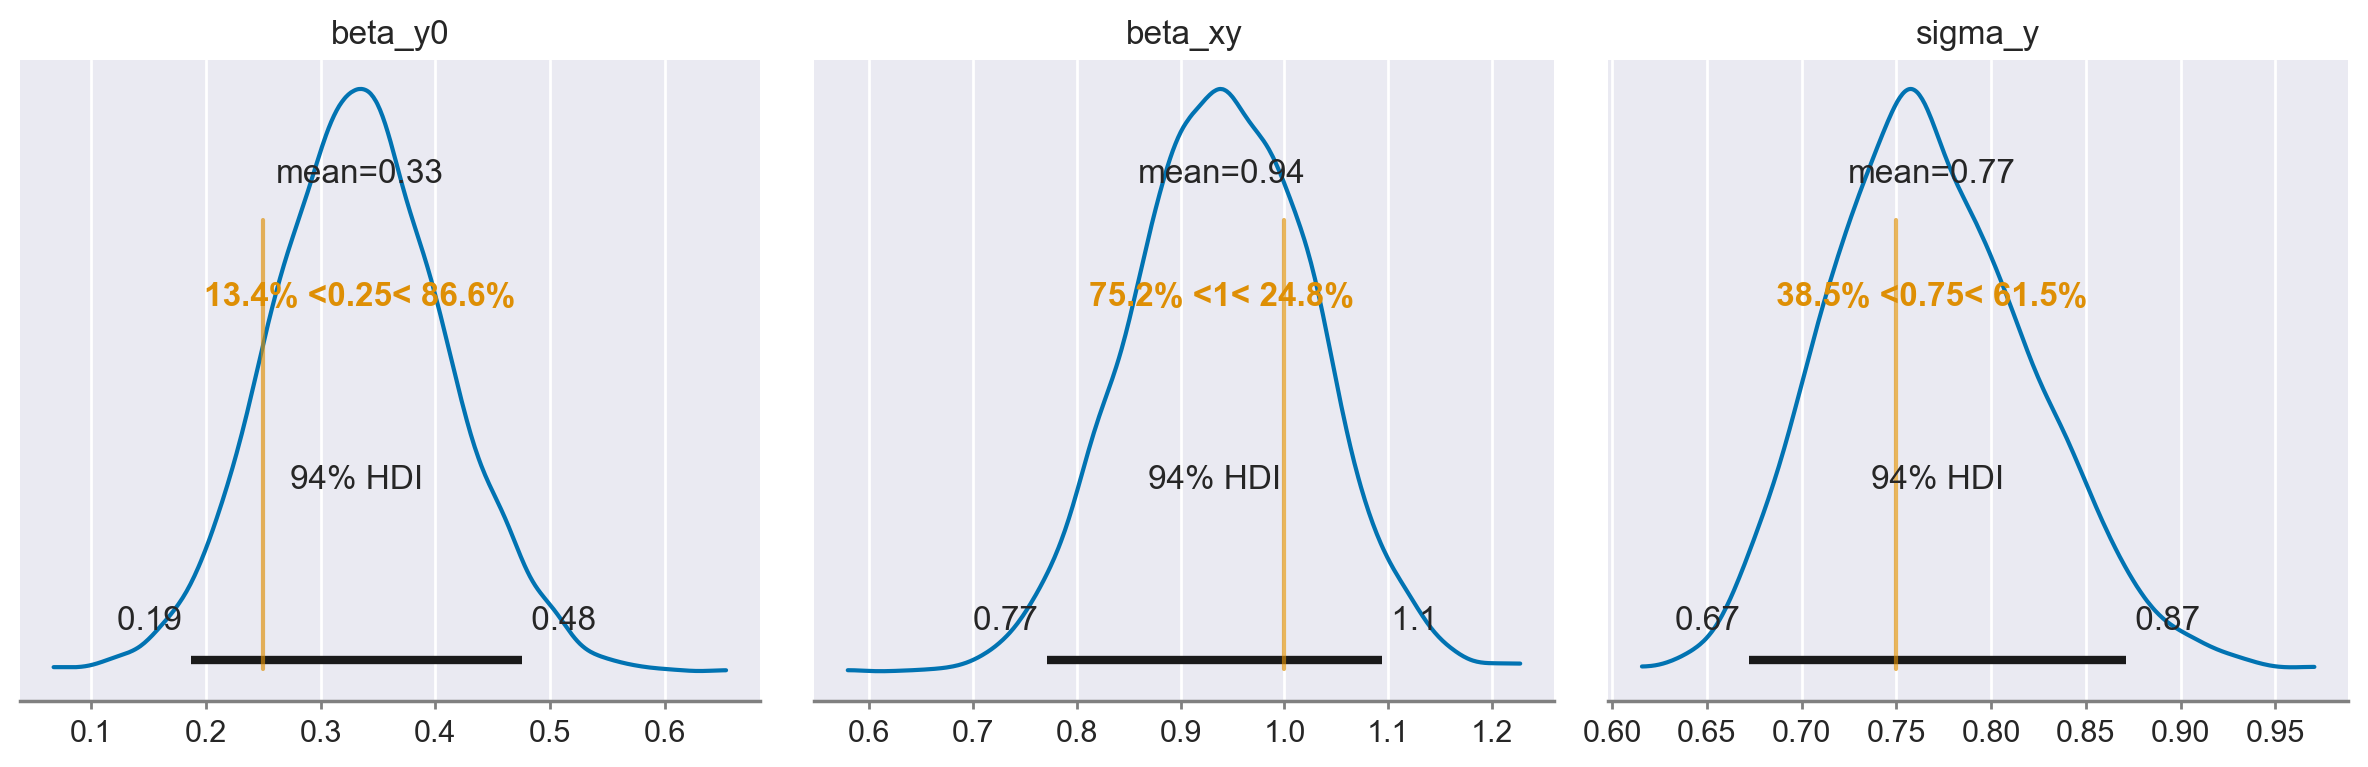

In [12]:
az.plot_posterior(
    idata1,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 4),
)
_ = plt.tight_layout()

In [13]:
model_inference2 = observe(model_generative, {"x": df["x"], "y": df["y"]})
model_inference2.set_dim("i", N, coord_values=np.arange(N))

In [14]:
with model_inference2:
    idata2 = pm.sampling_jax.sample_numpyro_nuts(random_seed=rng)

Compiling...


Compilation time = 0:00:00.547376


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1653.99it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1655.15it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1656.88it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1658.33it/s]


Sampling time = 0:00:01.270759


Transforming variables...


Transformation time = 0:00:00.052146


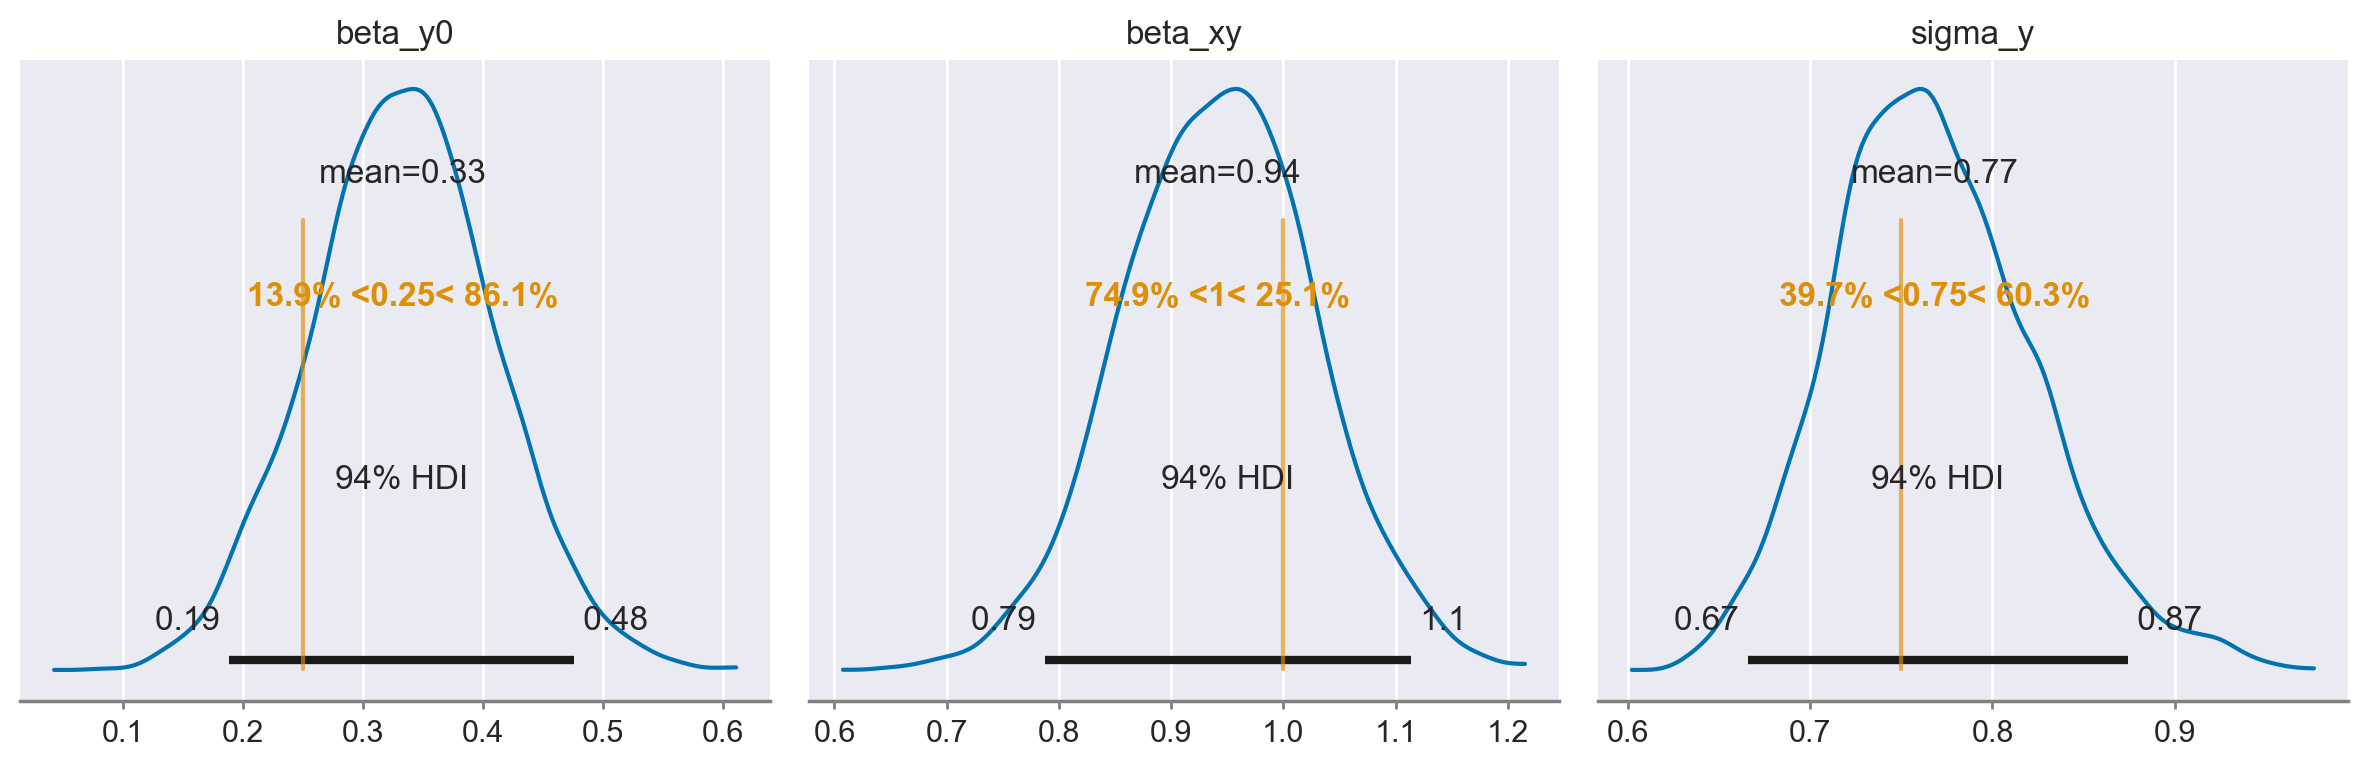

In [15]:
az.plot_posterior(
    idata2,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 4),
)
_ = plt.tight_layout()

In [16]:
%run ../wtrmrk.py

Watermark:
----------
Last updated: 2024-01-26T18:50:07.692770+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


